<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Building Models for Accuracy vs. Speed

This notebook analyses how various parameters influence model accuracy and inference speed. For evaluation, the popular [**COCO**](http://cocodataset.org/#home) dataset is used so that our numbers can be compared to published results. In addition, we show how to reproduce the accuracy of Torchvision's pre-trained Faster R-CNN model reported on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

Familiarity with the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook is assumed, and hence no explanation for repeated concepts or code provided. Instead, we focus on new aspects such as how to evaluate on the COCO dataset, or how to improve speed and accuracy. Training a new model on the COCO dataset, while not covered in this notebook, could be easily added by copying the respective cells from the 01_training_introduction notebook.



## Initialization

Import all the functions we need.

In [1]:
import sys
sys.path.append("../../")
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.detection.data import coco_labels, Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import plot_pr_curves
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Check if a GPU is present, since it is required by detector.evaluate().

In [3]:
assert torch.cuda.is_available()

---

# Prepare COCO Dataset

#### Download data

The COCO 2017 validation dataset is used in all our experiments following common practice for benchmarking object detection models. In particular, two `.zip` archives need to be downloaded from [http://cocodataset.org](http://cocodataset.org/#download): the actual images [2017 val images (1GB)](http://images.cocodataset.org/zips/val2017.zip) and the ground truth annotations [2017 train/val annotations (241MB)](http://images.cocodataset.org/annotations/annotations_trainval2017.zip).

The two files should be extracted and placed in a root-folder as shown below, with subfolders called *annotationsCOCO* and *images*:
```
/coco2017
+-- annotationsCOCO
|   +-- captions_train2017.json
|   +-- captions_val2017.json
|   +-- ...
+-- images
|   +-- 000000000139.jpg
|   +-- 000000000285.jpg
|   +-- ...
```


#### Convert COCO to VOC

Next, we need to convert the downloaded COCO annotations to Pascal VOC format in order to run this notebook. The function coco2voc does exactly that and only takes seconds to run. In the code below, we assume the COCO images and annotations are in the folder '/data/coco2017/'; the function then creates a new sub-directory called *annotations*. The function also, if activated, downloads the images provided their urls are specified in the `.json` file.


```python
from utils_cv.detection.data import coco2voc
coco2voc(
    anno_path = "/data/coco2017/annotationsCOCO/instances_val2017.json",
    output_dir = "/data/coco2017/",
    download_images = False
)
```

# Load Images

#### Path to data

The `DATA_PATH` variable should point to the COCO root directory which in the example above is `"/data/coco2017/"`. However, to try this notebook without having to download and convert COCO first, we set it below to use our fridge objects dataset.

In [4]:
# COCO dataset
#DATA_PATH = "/data/coco2017/"
#LABELS = coco_labels()[1:] #ignore first entry which is "__background__"

# Fridge objects dataset 
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
LABELS = ["can", "carton", "milk_bottle", "water_bottle"]

The `DATA_PATH` directory should contain the `annotations`, `images`, and when using COCO (albeit not used) `annotationsCOCO` folders.


In [5]:
os.listdir(DATA_PATH)

['annotations', 'annotationsCOCO', 'images']

#### Data loading

Most code in this notebook is taken from [01_training_introduction.ipynb](01_training_introduction.ipynb) with only small changes, mainly to ensure the class names (and ordering) in the `DetectionDataset` object matches those used to train the Torchvision model. Hence, in the cell below, we explicitly provide `labels` as input to the detection dataset.

Note that:
- The `DetectionDataset` object requires at least 1 image to be assigned to the training set, hence we set `train_pct=0.0001`.
- The first element returned by `coco_labels()` is "\_\_background\_\_" and is removed when setting `LABELS = coco_labels()[1:]`.
- We set `allow_negatives = True` since a few of the COCO images don't contain any annotated objects and hence don't have a correspoding `.xml` annotation file.

In [6]:
data = DetectionDataset(DATA_PATH, train_pct=0.0001, labels = LABELS, allow_negatives = True)
print(f"Number of test images: {len(data.test_ds)}")

Number of test images: 4999


The plots below summarize some aspects of the annotations, eg. the counts of ground truth boxes per class, or the distribution of absolute and relative widths/heights of the objects. 

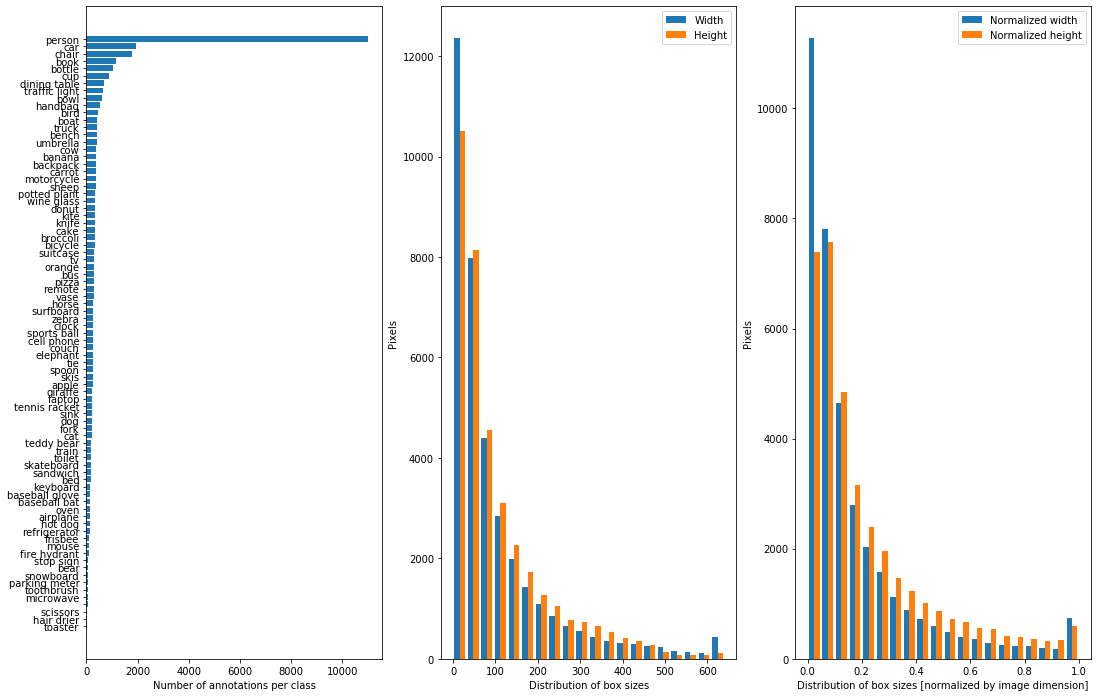

In [7]:
data.plot_boxes_stats(figsize = (18,12))

Lets visualize the annotations to make sure they look correct.

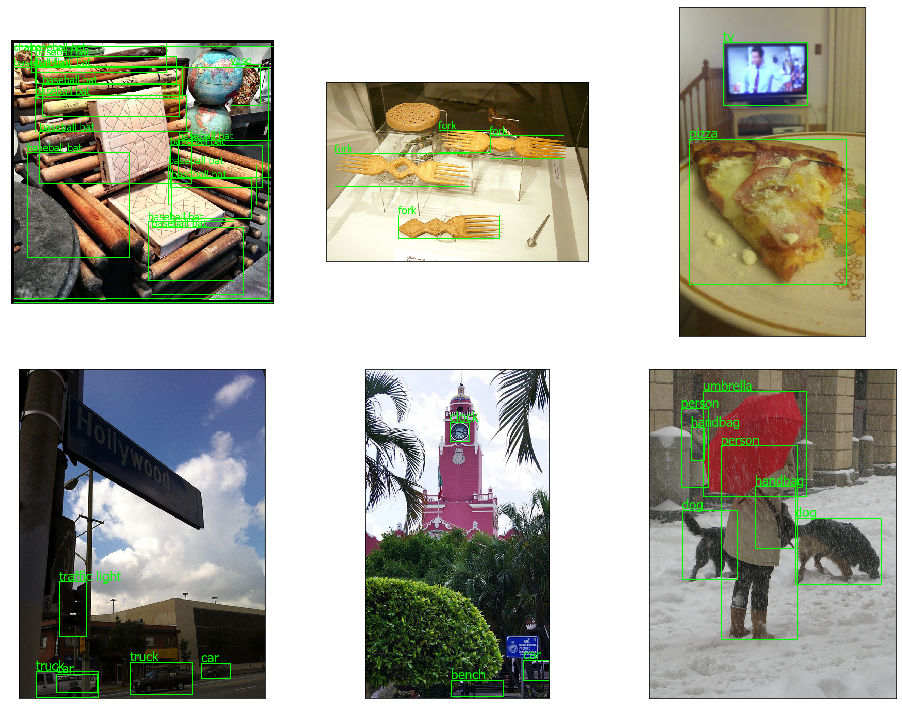

In [8]:
data.show_ims(rows=2)

# Reproduce reported accuracy

We now load the Faster-RCNN model (with [feature pyramid network](https://arxiv.org/pdf/1612.03144.pdf) extension) which was trained on COCO. In contrast to the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook, we do not create a new classification layer, but instead keep the existing last layer of the pre-trained model.

In [9]:
model = get_pretrained_fasterrcnn()
detector = DetectionLearner(data, model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


We can simply run the `evaluate()` method and observe that the mAP in the first row (for IoU=0.50:0.95) is close to the number reported on Torchvision's [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

In [10]:
e = detector.evaluate()

creating index...
index created!
Test:  [   0/2500]  eta: 9:24:55  model_time: 13.5113 (13.5113)  evaluator_time: 0.0156 (0.0156)  time: 13.5582  data: 0.0312  max mem: 1021
Test:  [ 100/2500]  eta: 0:10:38  model_time: 0.0781 (0.2215)  evaluator_time: 0.0156 (0.0183)  time: 0.1299  data: 0.0242  max mem: 1563
Test:  [ 200/2500]  eta: 0:07:38  model_time: 0.0781 (0.1539)  evaluator_time: 0.0156 (0.0183)  time: 0.1275  data: 0.0258  max mem: 1563
Test:  [ 300/2500]  eta: 0:06:27  model_time: 0.0781 (0.1317)  evaluator_time: 0.0156 (0.0178)  time: 0.1353  data: 0.0244  max mem: 1670
Test:  [ 400/2500]  eta: 0:05:45  model_time: 0.0937 (0.1209)  evaluator_time: 0.0156 (0.0176)  time: 0.1345  data: 0.0234  max mem: 1672
Test:  [ 500/2500]  eta: 0:05:16  model_time: 0.0781 (0.1147)  evaluator_time: 0.0156 (0.0176)  time: 0.1283  data: 0.0266  max mem: 1728
Test:  [ 600/2500]  eta: 0:04:51  model_time: 0.0781 (0.1103)  evaluator_time: 0.0156 (0.0173)  time: 0.1322  data: 0.0251  max mem: 177

In addition to the average precision/recall numbers, we can also plot the precision-recall curves for different IOU thresholds.

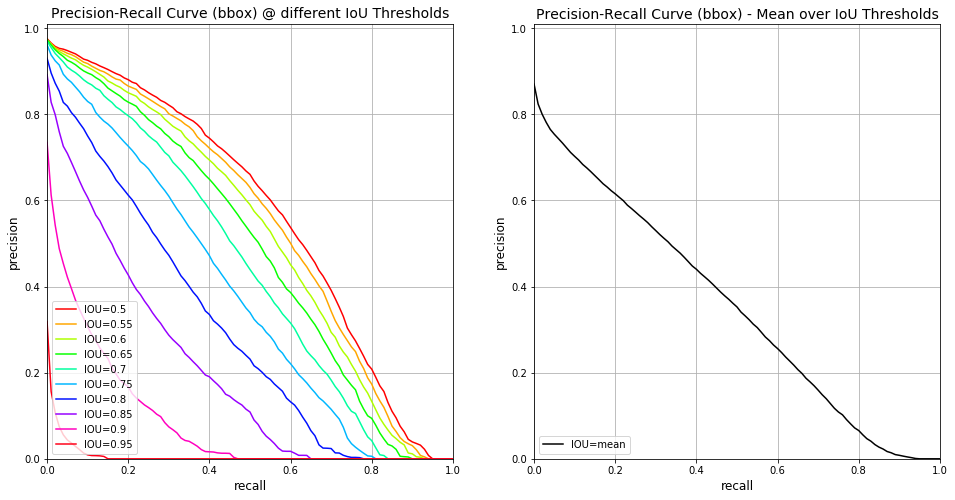

In [11]:
plot_pr_curves(e)

# Inference speed versus accuracy

**THIS SECTION WILL BE ADDED SOON**.

# Conclusion

This notebook illustrated the trade-off between inference time and accuracy induced by different parameter settings and using COCO as benchmark dataset. Additionally, it was shown how to reproduce the accuracy of Torchvision's pre-trained Faster R-CNN model as published on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.